_Since we announced [our collaboration with the World Bank and more partners to create the Open Traffic platform](https://mapzen.com/blog/announcing-open-traffic/), we’ve been busy. We’ve shared [two](https://mapzen.com/blog/open-traffic-osmlr-technical-preview/) [technical](https://mapzen.com/blog/osmlr-2nd-technical-preview/) previews of the OSMLR linear referencing system. Now we’re ready to share more about how we’re using [Mapzen Map Matching](https://mapzen.com/blog/map-matching/) to “snap” GPS-derived locations to OSMLR segments, and how we’re using a data-driven approach to evaluate and improve the algorithms._

# A "data-driven" approach to improving map-matching - Part III: 
## _POST-PROCESSING_
=============================================================================================

So far, we've seen how Mapzen uses synthetic GPS data to [validate](http://nbviewer.jupyter.org/github/opentraffic/reporter-quality-testing-rig/blob/23b90405f2d094c015a3438426a9a5d338b86c46/notebooks/map_matching_part_I.ipynb) the our map-matching results, and also how we use those validation metrics to [optimize](http://nbviewer.jupyter.org/github/opentraffic/reporter-quality-testing-rig/blob/master/notebooks/map_matching_part_II.ipynb) our algorithm performance for each one of our Open Traffic partners. For the third installment of our series on data-driven map-matching, we'll discuss the post-processing we do to ensure that only the best-quality matches make their way into the Open Traffic datastore.

## Background

As previously discussed [here](link to second blog post), Mapzen's map-matching algorithm relies on a kind of graphical model known as a Hidden Markov Model (HMM). Because HMM's are probabilistic in nature, the matches returned by the algorithm will always only be a best guess. Unfortunately, this best guess may still be quite far from the "truth" -- AKA **wrong**. 

To make sure we aren't serving up traffic conditions based on junk data, we would like some method for filtering out match results that just aren't realistic. One such approach we at Mapzen have developed is based on driving **driving speeds**.

## Hypothesis

Although GPS can often have very poor positional accuracy, its temporal measurements are rarely off by more than a [nanosecond](http://www.atomic-clock.galleon.eu.com/support/gps-time-accuracy.html). Because of this temporal precision, we can assert that any candidate route matched between two GPS data points must traverse its path in exactly the amount of time elapsed between the measurements. What this means is that a truly wacky match -- one that takes detours down side streets or doubles back on itself -- is going to have a lot of additional ground to cover in the same amount of time. In other words, the driver on this hypothetical, wacky route would have to be going _very_ fast.

The match error diagram from [Newton and Krumm (2009)](http://research.microsoft.com/en-us/um/people/jckrumm/Publications%202009/map%20matching%20ACM%20GIS%20camera%20ready.pdf) helps illustrate how we might construct a speed-based error metric:

<img src="krumm_newson_dist.png" alt="Drawing" style="width: 400px;" align="center"/>
<center><i>From Newton and Krumm (2009)</i></center>

Imagine that we have two GPS measurements on either end of the route shown above. Clearly, someone driving along the matched route would need to drive nearly twice as fast as someone on the correct route in order to traverse their paths in the same amount of time. Therefore, if we know that the average speed limit along the matched route is 50 km/h, and the speed we derive from our GPS measurements is 100 km/h, we probably have a bad match. Our hypothesis is that because bad matches are more likely to generate unreasonably high speeds relative to the known [speed limits](http://wiki.openstreetmap.org/wiki/Speed_limits) along a route, **we should therefore be able to identify bad matches based on the magnitude of this speed error**.

Below, we attempt to learn from our simulated GPS traces what the optimal threshold for such a speed-based error metric might be.

## 0. Setup test environment

In [197]:
import os
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
import numpy as np
from random import choice
import pandas as pd
%matplotlib inline

#### User vars

In [200]:
mapzenKey = os.environ.get('MAPZEN_API')
gmapsKey = os.environ.get('GOOGLE_MAPS')

## 1. Generate routes & metrics

For this analysis, we'll revert back to our original study area in San Francisco, CA

In [198]:
cityName = 'San Francisco'
minRouteLen = 1     # specified in km
maxRouteLen = 5     # specified in km
numRoutes = 100

In [4]:
routes = val.get_routes_by_length(cityName, minRouteLen, maxRouteLen, numRoutes, mapzenKey)

In [4]:
sampleRates = [1, 5, 10, 20, 30]    # specified in seconds
noiseLevels = np.linspace(0, 100, 21)    # specified in meters

The previous bits of code should look familiar to you if you've been following these map-matching tutorials from the beginning. The only difference here is that rather than scoring matches, we're interested in scoring speeds. Thus, we are only interested in the second object returned by the `get_route_metrics()` function, which correspond to the speed metric dataframe.

In [27]:
_, speedDf, _ = val.get_route_metrics(cityName, routes, sampleRates, noiseLevels, saveResults=True)

A random 5 entries from the speed metric dataframe:

In [15]:
speedDf.sample(5)

,matched,noise,pct_error,route_name,sample_rate,segment_id
206682,True,45.0,0.073008,Russell Ng_to_Lee Hecht Harrison,5.0,85569690162
271234,False,70.0,0.460363,Nan D Schlosberg_to_Total Logistics Resource Inc,10.0,825545579058
174527,True,10.0,-0.030170,Sweet Sue's_to_All Metals Welding,1.0,122272716425
248699,True,55.0,-0.086480,Something Very Special_to_ECOR Clothing Enterp...,10.0,500531484576
46216,False,85.0,0.373544,AAABE Co_to_Street P,30.0,287662511753


In [5]:
speedDf = pd.read_csv('london_speeds.csv')

## 2. Calculate and plot the optimal speed error threshold

We define speed error in the following way:
$$ \text{speed error} = \frac{\text{GPS-derived speed} - \text{known speed}}{\text{known speed}}$$

The optimal speed threshold is defined by the error that maximizes the difference between the CDFs of the speed error for matched and unmatched segments, shown below in blue and red, respectively. The point at which the threshold intersects the CDFs define the rate of **true positives** and **false positives**.

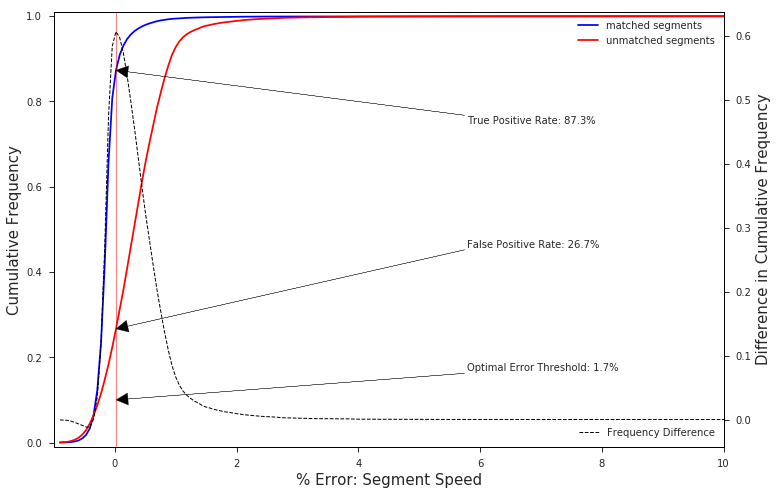

In [6]:
speedErrorThreshold = val.get_optimal_speed_error_threshold(speedDf, plot=True)

The chart above clearly shows that nearly 90% of correctly matched segments have a speed error rate of less than 1.7%, while nearly 75% of the unmatched segments, or false positive matches, lie above this value.

### Food for thought: Weighted Penalty Functions

We need not default to the optimal speed error threshold, which treats false positives and false negatives as equally "bad". For example, if a given customer/data provider cares more about mistakenly including bad data (Type I error) than missing good data (Type II error) a more conservative threshold can be chosen. The CDF plots above allow an analyst to visually inspect the impact that such discretionary adjustments will have on the outcome. These types of adjustments can also be performed in a programmatic fashion by assigning differential weights to our two types of error and thus shifting the optimal value itself.

## 3. Map-matching Accuracy with a Global Threshold

So, what kind of results can we expect from our "optimal" threshold?  We'll treat our threshold as a **binary classification** problem to compute the accuracy over some test data.

### a) Generate test data

In [ ]:
testRoutes = val.get_routes_by_length(cityName, minRouteLen, maxRouteLen, numRoutes, mapzenKey)
_, speedDf, _ = val.get_route_metrics(cityName, testRoutes, sampleRates, noiseLevels, saveResults=True)

### b) Score the results

**Statistical accuracy** measures the fraction of samples correctly identified as either true positives or true negatives, or in our case, matches and misses, respectively:

$$ \text{Accuracy} = \frac{\text{True Positives} \ + \ \text{True Negatives}}{\text{Total Population}} =  \frac{\text{# Matches Kept} \ + \ \text{# Misses Discarded}}{\text{# Segments}}$$

Here's how the accuracies compare across different sample rates and noise levels of our test data:

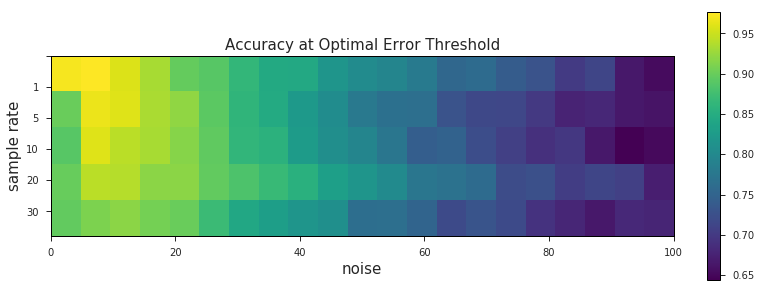

In [7]:
optimalAcc = val.plot_accuracy_heatmap(speedDf, [speedErrorThreshold], sampleRates, noiseLevels, kind='optimal')

Using a single threshold across all levels of data quality yields some interesting results. Unsurprisingly we get better match accuracy at lower levels of noise (ignoring some of the weirdness that occurs at 0 m noise, where we haven't perturbed our data at all). We're well within the ~90% accuracy range where it counts, at 40 m of noise and below. What's more interesting here, however, are the striation-like patterns that emerge across the 5 sample rate levels. This is probably the same phenomemon we saw [before](http://nbviewer.jupyter.org/github/opentraffic/reporter-quality-testing-rig/blob/master/notebooks/map_matching_part_I.ipynb#3.-Visualize-the-Scores), where slower sample frequencies were shown to be more robust against higher levels of noise.  

## 4. Map-matching Accuracy with Rate-based Thresholds

As we saw in the case study of [A-OK Rides](http://nbviewer.jupyter.org/github/opentraffic/reporter-quality-testing-rig/blob/master/notebooks/map_matching_part_II.ipynb#4.-Case-study:-"A-OK-Rides"), a fixed GPS sample rate can easily be set by a given data provider. If we know what this sample rate will be ahead of time, we can tune the speed-error threshold accordingly, and avoid using a globally-defined threshold for all sample rates. This should hopefully improve the overall accuracy of our matches.

In [16]:
thresholdRateDict = {}
thresholdsByRate = []
for r, rate in enumerate(sampleRates):
    df = speedDf[speedDf['sample_rate'] == rate]
    threshold = val.get_optimal_speed_error_threshold(df, plot=False, saveFig=False)
    thresholdsByRate.append(threshold)
    thresholdRateDict[str(int(sampleRates[r]))] = threshold

We now have 5 different thresholds -- one for each sample rate -- instead of one:

In [19]:
thresholdRateDict

{'1': 0,
 '10': 0.066631693373000012,
 '20': 0.053864199086380071,
 '30': 0.074422049226850029,
 '5': 0.020375927157593399}

We can now recalculate the statistical accuracy using the rate-specific thresholds...

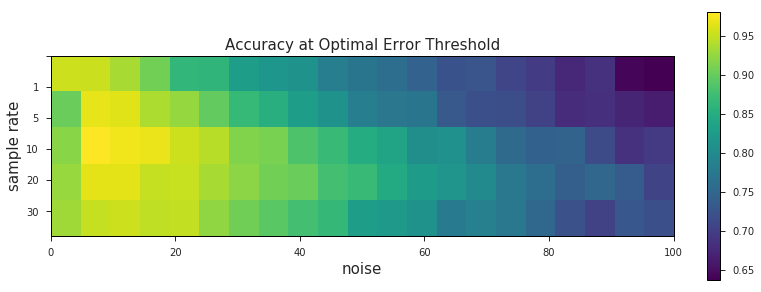

In [17]:
rateSpecificAcc = val.plot_accuracy_heatmap(speedDf, thresholdsByRate, sampleRates, noiseLevels, kind='rate')

...and visualize the change between the two:

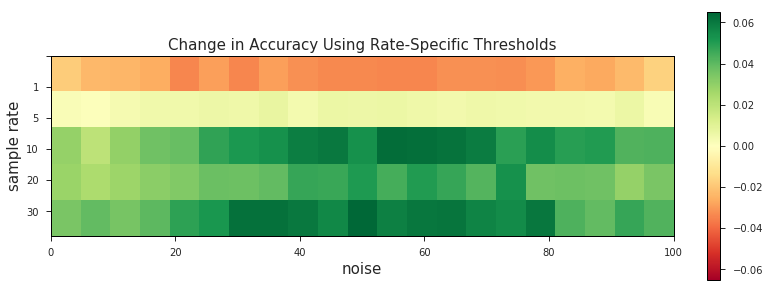

In [18]:
val.plot_change_in_acc(oneSizeFitsAll, accBySampleRate, sampleRates, noiseLevels)

These charts suggest that **prior knowledge of GPS sample rate can result in accuracy gains of up to ~6% when used in conjunction with the optimal speed error threshold**.


_\*\* N.B. - there are a number of reasons why the accuracy of 1 second sample rate matches might decrease when filtering based on the rate-specific threshold. The most likely explanation is that at a 1 s sample rate there either aren't enough false positives to pick a reliable threshold or the GPS-derived speeds of the false positives just aren't different enough from those generated by true positives._

## 5. Visually Inspect Speed-Based Filtering


Let's see our new junk-data filtering mechanism in action! Well test it for a hypothetical provider who collects GPS data at a 10 s sample rate with a 60 m standard deviation of noise:

### a) Get more routes

In [201]:
vizRoutes = val.get_routes_by_length(cityName, 0.5, 1, 50, mapzenKey)

### b) Pass the speed error threshold to `get_route_metrics()` as a argument!

In [103]:
sampleRates = [1, 5, 10, 20, 30]    # specified in seconds
noiseLevels = np.linspace(0, 100, 21)    # specified in meters
noiseLevels = [60]
sampleRates = [10]

In [60]:
matchDf, speedDf, densityDf = val.get_route_metrics(cityName,
    vizRoutes, sampleRates, noiseLevels,
    speedErrThreshold=thresholdRateDict['10'])

### c) Visualize the thresholding

In the map below we've styled the output of our sample routes in order to highlight the segments and their speeds that will either make their way into the datastore or get thrown out. This is simply a way of visualizing a process that in practice would occur entirely behind-the-scenes, and in the following order:

1. Generate a random route (**<span style="color:blue">&#9644;</span>**) to serve as our "ground truth"
2. Resample points (**<span style="color:blue">&#9673;</span>**) along the route at a user-defined sample rate
3. Add a semi-random amount of noise to [simulate GPS](http://nbviewer.jupyter.org/github/opentraffic/reporter-quality-testing-rig/blob/master/notebooks/map_matching_part_I.ipynb#2.-Iterate-Through-Routes,-Generate-Fake-GPS,-and-Score-the-Matches) (<div style="color:red; display: inline">&#9673;</div>)
4. Apply the predetermined speed-error threshold:
    * Send segments that do not exceed the threshold (**<span style="color:green">&#9644;</span>**) to the Open Traffic datastore
    * Filter out segments that exceed the threshold (**<span style="color:red">&#9644;</span>**)
    * Filter out segments for whom speeds could not be calculated (**<span style="color:yellow">&#9644;</span>**)

Here we'll get the list of all the geojson files that were created when we synthesized new GPS traces...

In [202]:
dataDir = '../data/sf50thresholdViz/'
geojsonList = [trace for trace in os
               .listdir(dataDir) if trace.endswith('json')]

...and run the following cell repeatedly to iterate through the routes to view them, along with their matches, on a slippy map!

In [217]:
fname = dataDir + geojsonList.pop()
m = val.generate_route_map_2(fname, 17)
m

There's a lot to look at here, but there are two important takeaways illustrated by the map above:
* The section of the matched route that deviates from the "ground truth" has been **correctly identified** by our speed-error threshold as a **bad match** as indicated by the <span style="color:red">red</span> color. In other words, the threshold seems to be doing its job.
* Zooming in on the map, it seems our threshold has _misclassified_ the east-west portion of the route along Cesar Chavez St. as a bad match, when it clearly is not. This suggests that our threshold may be doing its job a bit **too well**, at least in this instance.

## 6. Results

Ultimately, the speed-error threshold seems to be doing its job of identifying the truly egregious, detour-style down-and-back mismatches that are caused by noisy GPS data and very difficult to avoid with map-matching alone. Although the "optimal" threshold we derived may be on conservative side (i.e. lends itself to Type II error), it's not hard to image why certain Open Traffic partners may wish to err on the side of caution. We, personally, would much rather have gaps in coverage than get our users stuck in traffic. As far as what our data providers/partners/users prefer, well, we think thats a conversation worth having. What we've shown here is a methodology for approaching that conversation in a more **informed** and **statistically rigorous** way.